In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.datasets import fetch_mldata, fetch_lfw_people
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

### Image Classification with Dimensionality Reduction
### (a) i. Load two datasets: MNIST (number recognition), LFW (face recognition).

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

mnist = fetch_mldata('MNIST original')
lfw = fetch_lfw_people()

### (a) ii. Split each dataset into a 75/25 train/test split.

In [6]:
mnist['data'].shape

(70000, 784)

In [7]:
mnist['target'].shape

(70000,)

In [8]:
# sample part of the dataset for speed
mnist_small_idx = np.random.randint(0,70000,size=2000)

In [12]:
mnist_X_train_original, mnist_X_test_original, mnist_Y_train, mnist_Y_test = train_test_split(mnist['data'][mnist_small_idx], mnist['target'][mnist_small_idx], random_state=123, shuffle=False)

lfw_X_train_original, lfw_X_test_original, lfw_Y_train, lfw_Y_test = train_test_split(lfw.data, lfw.target, random_state=456, shuffle=False)

In [13]:
def plot_explained_variance(n_feature, X_train):
    pca = PCA(n_feature)
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()

### (b) Feature sizes: For each dataset, train and evaluate two clssification algorithms (e.g., SVM, Naive Bayes, Decision Tree, KNN) with at least 25 different feature dimension sizes. To achieve the different feature dimension sizes, you will need to vary the number of principal components you keep using the unsupervised dimensionality reduction algorithm PCA. (Code)
### (c) Report the predictive performance of each classifier on each dataset as a function of the feature dimension size (i.e., number of principal components). As a result, your write-up should include four plots to show results for both classifications algorithms on both datasets. (Write-up)

### (b) MNIST

In [15]:
sc = StandardScaler()
mnist_X_train = sc.fit_transform(mnist_X_train_original)
mnist_X_test = sc.transform(mnist_X_test_original)

/Users/edithzeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


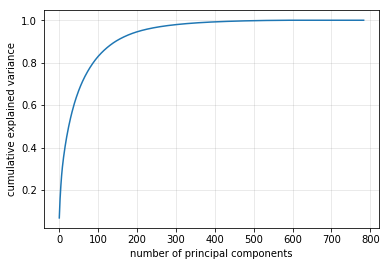

In [16]:
plot_explained_variance(784, mnist_X_train)

The explained variance indicates that over 80% of the original data's variability can be explained with about 200 principal components (the elbow in the curve). Using additional principal components gives us diminishing returns as the growth in variance decreases. Judging by the graph the hypothesis is that a classifier can achieve good performance with approximately 200 or less principal components. To test this hypothsis, I will vary the number of principal components and evaluate the linear SVM classifier and a KNN classifer's performances on the dimensionality-reduced MNIST dataset.

In [17]:
C_list = [0.1, 1.0, 10.0]
K_list = [5, 10, 20, 40, 60, 120]
feature_dim_list = [2, 5, 10, 20, 30] + [i*2 for i in range(20, 120)]

In [18]:
def preprocess_pca(X_train, X_test, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca    

#### MNIST - SVM

In [19]:
def svm(X_train, X_test, Y_train, Y_test):
    
    # cross validate to select optimal C
    cv_scores = []
    for n in C_list:
        cv_model = LinearSVC(loss='hinge', C=n, random_state=7)
        kf = KFold(n_splits=10, shuffle=False, random_state=1)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    
    # test accuracy
    best_c = C_list[cv_scores.argmax()]
    model = LinearSVC(loss='hinge', C=best_c, random_state=7)
    model.fit(X_train, Y_train)

    return model.score(X_test, Y_test)

In [ ]:
mnist_svm_scores = []

for dim in feature_dim_list:
    X_train, X_test = preprocess_pca(mnist_X_train, mnist_X_test, r=2)
    mnist_svm_scores.append(svm(X_train, X_test, mnist_Y_train, mnist_Y_test))

mnist_svm_scores = np.asarray(mnist_svm_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list, mnist_svm_scores)

plt.xlabel("number of principal components")
plt.ylabel("linear SVM classifier accuracy")
print("Optimal number of principal components for linear SVM on MNIST:", feature_dim_list[mnist_svm_scores.argmax()])

#### (c) MNIST - SVM - write up


#### MNIST - KNN

In [20]:
def knn(X_train, X_test, Y_train, Y_test):
    
    # cross validate to select optimal K
    cv_scores = []
    for k in K_list:
        cv_model = KNeighborsClassifier(n_neighbors=k)
        kf = KFold(n_splits=10, shuffle=False, random_state=1)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    
    # test accuracy
    best_k = K_list[cv_scores.argmax()]
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, Y_train)

    return model.score(X_test, Y_test)

In [ ]:
mnist_knn_scores = []

for dim in feature_dim_list:
    X_train, X_test = preprocess_pca(mnist_X_train, mnist_X_test, r=2)
    mnist_knn_scores.append(knn(X_train, X_test, mnist_Y_train, mnist_Y_test))

mnist_knn_scores = np.asarray(mnist_knn_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list, mnist_knn_scores)

plt.xlabel("number of principal components")
plt.ylabel("KNN classifier accuracy")
print("Optimal number of principal components for KNN on MNIST:", feature_dim_list[mnist_knn_scores.argmax()])

#### (c) MNIST - KNN - write up

### (b) LFW

In [17]:
lfw.data.shape

(13233, 2914)

In [18]:
sc2 = StandardScaler()
lfw_X_train = sc2.fit_transform(lfw_X_train_original)
lfw_X_test = sc2.transform(lfw_X_test_original)

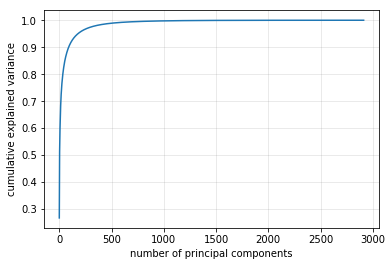

In [19]:
plot_explained_variance(2914, lfw_X_train)

The LFW dataset has a higher dimension (2914) than the MNIST dataset (784). The plot suggests that using approximately 300 or less principal components suffices.

In [33]:
feature_dim_list_lfw = [i*5 for i in range(1,70)]
trees=[2,10,30,70,100,150,200,250]

#### LFW - Naive Bayes 

In [32]:
def nb(X_train, X_test, Y_train, Y_test):
    model = GaussianNB()
    model.fit(X_train, Y_train)
    return model.score(X_test, Y_test)

Optimal number of principal components for Naive Bayesian classifier on LFW: 28


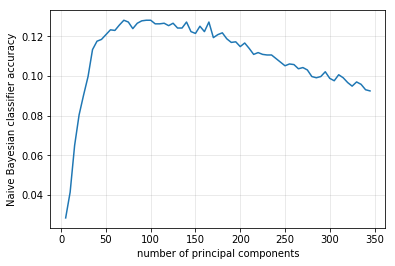

In [119]:
lfw_nb_scores = []
for dim in feature_dim_list_lfw:
    X_train, X_test = preprocess_pca(lfw_X_train, lfw_X_test)
    lfw_nb_scores.append(nb(X_train, X_test, lfw_Y_train, lfw_Y_test))
lfw_nb_scores = np.asarray(lfw_nb_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list_lfw, lfw_nb_scores)

plt.xlabel("number of principal components")
plt.ylabel("Naive Bayesian classifier accuracy")
print("Optimal number of principal components for Naive Bayesian classifier on LFW:", feature_dim_list[lfw_nb_scores.argmax()])

#### (c) LFW - Naive Bayes - Write up 

#### LFW - Random Forest

In [31]:
def rf(X_train, X_test, Y_train, Y_test, fold=10):
    cv_scores = []
    for t in trees:
        model = RandomForestClassifier(n_estimators=t, max_features='sqrt', oob_score=True, warm_start=True)
        model.fit(X_train, Y_train)
        score = model.oob_score_
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    
    best_t = trees[cv_scores.argmax()]
    model = RandomForestClassifier(n_estimators=best_t, max_features='sqrt')
    model.fit(X_train, Y_train)

    return model.score(X_test, Y_test)

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

lfw_rf_scores = []
for dim in feature_dim_list_lfw:
    X_train, X_test = preprocess_pca(lfw_X_train, lfw_X_test)
    lfw_rf_scores.append(rf(X_train, X_test, lfw_Y_train, lfw_Y_test))
lfw_rf_scores = np.asarray(lfw_rf_scores)

plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(feature_dim_list_lfw, lfw_rf_scores)

plt.xlabel("number of principal components")
plt.ylabel("Random Forest classifier accuracy")
print("Optimal number of principal components for random forest classifier on LFW:", feature_dim_list[lfw_rf_scores.argmax()])

KeyboardInterrupt: 

#### LFW - Random forest - write up

### (d) Write a discussion analyzing the influence of applying PCA on the classiffication performance. For example, what feature dimension sizes were better/worse and why do you think so? What can you infer by observing the classiffcation performance across the different datasets and different classiffcation algorithms? Your discussion should consist of two to four paragraphs. (Write-up)